# ĐỒ ÁN CUỐI KỲ
## Nhóm 07

### Thành viên
1. Lưu Hữu Tình - 21424056
2. Đặng Hồ Hoàng Duy - 21424073
3. Huỳnh Văn Thái - 21424088

<h1>
<font color="blue">Chủ đề: THU THẬP DỮ LIỆU THÔNG TIN CÁC ĐỘI BÓNG</font>
</h1>

# PHẦN 1: QUY TRÌNH KHOA HỌC DỮ LIỆU

## A. Thu thập dữ liệu (Data collection)

In [ ]:
# Run with google colab
# from google.colab import drive
# drive.mount('/content/drive')

<b>Import</b>

Cài đặt các thư viện, gói cho việc collect data


In [ ]:
!pip install scrapy
!pip install spider3

In [2]:
import json
import re
import pandas as pd
import scrapy
from pandas.testing import assert_frame_equal
import datetime
import matplotlib.pyplot as plt

Bóng đá là môn thể thao hấp dẫn nhất hành tinh. Chúng ta sẽ khởi động môn học bằng việc thu thập dữ liệu của các CLB bóng đá. SoFIFA (https://sofifa.com/) là một trang web lưu trữ dữ liệu của các CLB trong trò chơi bóng đá nổi tiếng FIFA 23 mà có các chỉ số phản ánh gần đúng với phong độ của các CLB bóng đá ngoài đời. Trong phần này, nhiệm vụ đầu tiên là cần thu thập ID của các CLB.

#### Tạo một project mới với scrapy

Để sử dụng thư viện scrapy sau khi cài đặt xong, gọi câu lệnh như bên dưới để bắt đầu tạo một project mới với scrapy với tên gọi là `fifa_crawler`.

In [3]:
!scrapy startproject fifa_crawler

New Scrapy project 'fifa_crawler', using template directory '/usr/local/lib/python3.10/dist-packages/scrapy/templates/project', created in:
    /content/fifa_crawler

You can start your first spider with:
    cd fifa_crawler
    scrapy genspider example example.com


In [4]:
cd fifa_crawler/fifa_crawler

/content/fifa_crawler/fifa_crawler


Sau khi tạo xong project với scrapy, vì thu thập dữ liệu với thư viện này không cho phép xài notebook trực tiếp nên các bạn sau khi hoàn thành xong class `collect_team_url` (scrapy.Spider) ở bên dưới, tạo một file có tên `collect_teams_urls.py` vào đường dẫn sau `fifa_crawler/fifa_crawler/spiders/collect_teams_urls.py`.

<b>Tạo file collect_teams_urls.py</b>

1. File sẽ collect data từ trang https://sofifa.com/teams?col=oa&sort=desc&offset=0
2. Cấu trúc trả về là json, danh sách các url của mỗi đội bóng
```json
[
{"team_url": "/team/10"},
{"team_url": "/team/21"},
...
]
```

In [5]:
# File: \fifa_crawler\fifa_crawler\spiders\collect_teams_urls.py
import scrapy

class collect_team_url(scrapy.Spider):
  name='teams_urls' 
  
  def start_requests(self):
    urls = ['https://sofifa.com/teams?col=oa&sort=desc&offset=0']
    
    # YOUR CODE HERE
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    for i in range(1,13):
        # Mỗi trang hiển thị 60 cầu thủ
        url = f'https://sofifa.com/teams?col=oa&sort=desc&offset={i*60}' 
        urls.append(url)

    for url in urls:
      yield scrapy.Request(url=url, headers=headers, callback=self.parse)

  def parse(self, response):
    # <td class="col-name-wide"> 
    #  <a href="/team/10/manchester-city/">
    team_urls = response.css('td.col-name-wide a::attr(href)').extract()
    team_ids = []
    for url in team_urls:
      # Get team /team/10
      if url.split('/')[1] == "team":
        team_id = url.split('/')[2]
        team_url = f"/team/{team_id}"
        team_item = {"team_url": team_url}
        yield team_item

<b>Start collect data từ file collect_teams_urls.py</b>

Data collect được lưu vào dataset/teams_urls.json

In [ ]:
# Remove file data collect if exist
#!rm /content/fifa_crawler/fifa_crawler/dataset/teams_urls.json

# Local notebook
!rm /dataset/teams_urls.json

# Crawl data
!scrapy crawl teams_urls -o dataset/teams_urls.json

In [7]:
# Google colab
#path_teams_urls_json = "/content/fifa_crawler/fifa_crawler/dataset/teams_urls.json"

# Local notebook
path_teams_urls_json = "dataset/teams_urls.json"
with open(path_teams_urls_json) as f:
    data = json.load(f)

print('Danh sách bao gồm', len(data), 'ID của các CLB.')


Danh sách bao gồm 711 ID của các CLB.


Sau khi đã có danh sách 712 ID của các CLB đã thu thập từ trang web SoFIFA, bạn sẽ tiến hành thu thập dữ liệu cụ thể của từng CLB ứng với các ID này bằng cách hoàn thành class `collect_team_info`(scrapy.Spider) như bên dưới.

<b>Tạo file collect_teams_info.py</b>

1. Thu thập thông tin chi tiết của mỗi đội bóng
2. Trả về data dạng json
```json
[
{
    "Name": "Chelsea", 
    "League": "[England] Premier League", 
    "Overall": "83", 
    "Attack": "83", 
    "Midfield": "81", 
    "Defence": "82", 
    "Home stadium": "Stamford Bridge", 
    "Rival team": "Arsenal", 
    "International prestige": "8", 
    "Domestic prestige": "9", 
    "Club worth": "\n", 
    "Starting XI average age": "24.55", 
    "Whole team average age": "24.39", 
    "Captain": "R. James", 
    "Short free kick": "R. James", 
    "Long free kick": "E. Fernández", 
    "Left short free kick": "João Félix", 
    "Right short free kick": "R. James", 
    "Penalties": "K. Havertz", 
    "Left corner": "B. Chilwell", 
    "Right corner": "R. James"
},
    ...
]
```

In [8]:
# \fifa_crawler\fifa_crawler\spiders\collect_teams_info.py
import scrapy
import json
import re
import datetime

class collect_team_info(scrapy.Spider):
  name='teams_info'
  
  def __init__(self):
    try:
      with open('dataset/teams_urls.json') as f:
        self.teams = json.load(f)
      self.team_count = 1
    except IOError:
      print("File not found")

  def start_requests(self):
    # YOUR CODE HERE
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    for team in self.teams:
      # https://sofifa.com/team/10
      url = 'https://sofifa.com' + team['team_url'] + '?units=mks'
      yield scrapy.Request(url=url, headers=headers, callback=self.parse)
  
  def parse(self, response):
      # YOUR CODE HERE
      team_info = {}

      team_info["Name"] = response.css('div.info h1::text').get();

      team_info["League"] = response.css('div.meta.ellipsis a::text').get()

      ratings = response.css('section.card .bp3-tag.p::text').getall()

      team_info["Overall"] = ratings[0]

      team_info["Attack"] = ratings[1]
      
      team_info["Midfield"] = ratings[2]
      
      team_info["Defence"] = ratings[3]

      team_info["Home stadium"] = response.css('ul.pl li.ellipsis:contains("Home stadium")::text').get()
      
      team_info["Rival team"] = response.css('ul.pl li:contains("Rival team") a::text').get()

      team_info["International prestige"] = response.css('ul.pl li:contains("International prestige") span::text').get()

      team_info["Domestic prestige"] = response.css('ul.pl li:contains("Domestic prestige") span::text').get()

      team_info["Club worth"] =response.xpath('//li[contains(label, "Club worth")]/text()').re_first(r'€([\d\.]+)M')

      team_info["Starting XI average age"] = response.css('ul.pl li:contains("Starting XI average age")::text').get()

      team_info["Whole team average age"] = response.css('ul.pl li:contains("Whole team average age")::text').get()

      team_info["Captain"] = response.css('ul.pl li:contains("Captain") a::text').get()

      team_info["Short free kick"] = response.css('ul.pl li:contains("Short free kick") a::text').get()

      team_info["Long free kick"] = response.css('ul.pl li:contains("Long free kick") a::text').get()

      team_info["Left short free kick"] = response.css('ul.pl li:contains("Left short free kick") a::text').get()
      
      team_info["Right short free kick"] = response.css('ul.pl li:contains("Right short free kick") a::text').get()
      
      team_info["Penalties"] = response.css('ul.pl li:contains("Penalties") a::text').get()
      
      team_info["Left corner"] = response.css('ul.pl li:contains("Left corner") a::text').get()
      
      team_info["Right corner"] = response.css('ul.pl li:contains("Right corner") a::text').get()

      yield team_info

Sau khi đã hoàn thành class ở trên và lưu lại trong file `collect_teams_info.py`, các bạn sẽ tiếp tục chạy câu lệnh bên dưới để thu thập thông tin chi tiết của toàn bộ 712 CLB và xuất ra file `teams_info.json` ở cùng đường dẫn dataset như trên.

**Chú thích:**
- Do trang web  `https://sofifa.com/` đang giới hạn số lượng yêu cầu trên mỗi khoảng thời gian để tránh quá tải. Việc này ảnh hưởng đến việc crawl dữ liệu không đầy đủ.

```sh
DOWNLOAD_DELAY = 0.5
```

Để khắc phục sự cố này, bạn có thể thêm độ trễ giữa mỗi yêu cầu để bạn không gửi quá nhiều yêu cầu trong một khoảng thời gian ngắn. Bạn có thể thực hiện việc này bằng cách sử dụng cài đặt `DOWNLOAD_DELAY` trong tệp `settings.py` của dự án Scrapy của mình. Ví dụ: bạn có thể đặt thành `DOWNLOAD_DELAY = 0.5` để đợi 0.5 giây giữa mỗi yêu cầu.

<b>Start collect data từ file collect_teams_info.py</b>

Data collect được lưu vào dataset/teams_info.json

In [ ]:
# remove data collect if exist
#!rm /content/fifa_crawler/fifa_crawler/dataset/teams_info.json

# Local notebook
!rm /dataset/teams_info.json

!scrapy crawl teams_info -o dataset/teams_info.json

<b>Đọc thông tin collect được lưu vào biến df</b>

In [10]:
ls

dataset/     items.py        pipelines.py  settings.py
__init__.py  middlewares.py  __pycache__/  spiders/


In [11]:
#df = pd.read_json('dataset/teams_info.json', encoding='utf-8-sig')
# Google colab
#file_path_teams_info_json = '/content/fifa_crawler/fifa_crawler/dataset/teams_info.json'

# Local notebook
file_path_teams_info_json = 'dataset/teams_info.json'

df = pd.read_json(file_path_teams_info_json, encoding='utf-8-sig')

print("Bảng gồm ",df.shape[1]," thuộc tính (trường dữ liệu) và ",len(df)," dòng (records).")



Bảng gồm  21  thuộc tính (trường dữ liệu) và  711  dòng (records).


In [12]:
df.tail()

,Name,League,Overall,Attack,Midfield,Defence,Home stadium,Rival team,International prestige,Domestic prestige,...,Starting XI average age,Whole team average age,Captain,Short free kick,Long free kick,Left short free kick,Right short free kick,Penalties,Left corner,Right corner
706,Värnamo,[Sweden] Allsvenskan,63,68,64,62,Euro Park,Elfsborg,1,1.0,...,24.64,23.93,O. Johansson,O. Johansson,O. Johansson,O. Johansson,O. Johansson,O. Johansson,O. Johansson,O. Johansson
707,Gillingham,[England] League Two,62,63,62,61,Court Lane,Swindon Town,1,6.0,...,28.18,26.18,S. Williams,S. Williams,S. Williams,S. Williams,S. Williams,T. Nichols,G. Lapslie,S. Williams
708,Walsall,[England] League Two,62,63,61,62,Court Lane,Shrewsbury Town,1,7.0,...,25.27,24.52,D. Daniels,I. Hutchinson,I. Hutchinson,I. Hutchinson,I. Hutchinson,J. Matt,I. Hutchinson,I. Hutchinson
709,Bradford City,[England] League Two,62,63,62,62,Ivy Lane,Leeds United,1,9.0,...,26.18,25.89,R. Smallwood,J. Walker,R. Smallwood,J. Walker,J. Walker,A. Cook,R. Smallwood,R. Smallwood
710,Kristiansund,[Norway] Eliteserien,62,63,62,62,Town Park,Molde,1,4.0,...,26.09,23.18,A. Hopmark,C. Aasbak,C. Aasbak,C. Aasbak,S. Nilsen,M. Mawa,C. Aasbak,C. Aasbak


## B. Khám phá dữ liệu (thường đan xen với tiền xử lý dữ liệu)

1. Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

* Mỗi dòng trong bảng này tương ứng với thông tin về một đội bóng.  

*  Nếu mỗi đội bóng trong bảng đều có thông tin khác nhau, điều này có ý nghĩa rất quan trọng. 

  > Bảng này chứa thông tin chi tiết về các đội bóng, bao gồm điểm số, ngân sách, độ tuổi, cầu thủ xuất sắc, sân nhà và nhiều yếu tố khác. 
  
  > Các thông tin này là **quan trọng trong việc phân tích và so sánh hiệu suất của các đội bóng**, đưa ra dự đoán và quyết định về các cược và cách chơi trong các trận đấu. 
  
  >Nếu tất cả các đội bóng trong bảng đều có thông tin giống nhau, thì bảng sẽ không có giá trị trong việc phân tích và so sánh hiệu suất của các đội bóng đó. 

Tuy nhiên, nếu mỗi đội bóng trong bảng đều có thông tin khác nhau, thì bảng sẽ cung cấp cho chúng ta **một tài nguyên quý giá** trong việc **tìm hiểu và đưa ra các quyết định về các đội bóng trong các giải đấu bóng đá**.


2.Mỗi cột có ý nghĩa gì?

- Các cột trong dữ liệu này có ý nghĩa như sau:

| Field | Description |
| --- | --- |
| Name | Tên đội bóng. |
| League | Tên giải đấu mà đội bóng đang tham gia. |
| Overall | Điểm số tổng thể của đội bóng. Khoảng biểu diễn [1, 100].|
| Attack | Điểm số tấn công của đội bóng. Khoảng biểu diễn [1, 10]. |
| Midfield | Điểm số tiền vệ của đội bóng. Khoảng biểu diễn [1, 100]. |
| Defence | Điểm số phòng thủ của đội bóng. Khoảng biểu diễn [1, 100]. |
| Home stadium | Sân nhà của đội bóng. |
| Rival team | Đối thủ chính của đội bóng. |
| International prestige | Độ uy tín của đội bóng trong các giải đấu quốc tế. Khoảng biểu diễn [1, 10]. |
| Domestic prestige | Độ uy tín của đội bóng trong các giải đấu trong nước. Khoảng biểu diễn [1, 10]. |
| Transfer budget | Ngân sách chuyển nhượng của đội bóng. Khoảng biểu diễn [€100.0M, €10.0B]. |
| Starting XI average age | Tuổi trung bình của đội hình xuất phát. Khoảng biểu diễn [18, 30]. |
| Whole team average age | Tuổi trung bình của toàn đội bóng. Khoảng biểu diễn [18, 30].  |
| Captain | Tên cầu thủ đội trưởng của đội bóng. |
| Short free kick | Cầu thủ thực hiện đá phạt ngắn. |
| Long free kick | Cầu thủ thực hiện đá phạt dài. |
| Left short free kick | Cầu thủ thực hiện đá phạt ngắn bên trái. |
| Right short free kick | Cầu thủ thực hiện đá phạt ngắn bên phải. |
| Penalties | Cầu thủ thực hiện đá phạt đền. |
| Left corner | Cầu thủ thực hiện đá phạt góc bên trái. |
| Right corner | Cầu thủ thực hiện đá phạt góc bên phải. |

3. Mỗi cột hiện đang có kiểu dữ liệu gì? Khoảng biểu diễn của kiểu dữ liệu đó ra sao?
Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?

* Sau khi tạo DataFrame, chúng ta có thể sử dụng phương thức info() để xem thông tin tổng quan về dữ liệu:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     711 non-null    object 
 1   League                   711 non-null    object 
 2   Overall                  711 non-null    int64  
 3   Attack                   711 non-null    int64  
 4   Midfield                 711 non-null    int64  
 5   Defence                  711 non-null    int64  
 6   Home stadium             686 non-null    object 
 7   Rival team               711 non-null    object 
 8   International prestige   711 non-null    int64  
 9   Domestic prestige        676 non-null    float64
 10  Club worth               654 non-null    float64
 11  Starting XI average age  711 non-null    float64
 12  Whole team average age   711 non-null    float64
 13  Captain                  711 non-null    object 
 14  Short free kick          7

Qua đó ta có thể thấy:

* Dữ liệu có 712 dòng và 21 cột.

* Các cột chứa các kiểu dữ liệu khác nhau: int64, float64, và object...

<b>Kết luận:</b> Các một số cột có kiểu dữ liệu không phù hợp để xử lý tiếp. Tuy nhiên, có thể cần chuyển đổi kiểu dữ liệu của một số cột để phù hợp hơn với các phép tính và xử lý dữ liệu, Ví dụ như chuyển đổi kiểu dữ liệu của cột "Overall" từ chuỗi sang số thực.

In [14]:
# Chuyển kiểu dữ liệu của các cột số thành kiểu số liên tục
df['Overall'] = pd.to_numeric(df['Overall'], errors='coerce')
df['Attack'] = pd.to_numeric(df['Attack'], errors='coerce')
df['Defence'] = pd.to_numeric(df['Defence'], errors='coerce')
df['Midfield'] = pd.to_numeric(df['Midfield'], errors='coerce')
df['International prestige'] =  pd.to_numeric(df['International prestige'], errors='coerce')
df['Domestic prestige'] = pd.to_numeric(df['Domestic prestige'], errors='coerce')
df['Whole team average age'] = pd.to_numeric(df['Whole team average age'], errors='coerce')



* Với mỗi cột, dữ liệu phân bố như thế nào? Để phân tích phân bố dữ liệu của từng cột, ta cần biểu diễn các giá trị trong cột dưới dạng biểu đồ phù hợp. Một số cách để thực hiện phân tích phân bố dữ liệu bao gồm sử dụng biểu đồ tần suất (histogram), biểu đồ hộp (box plot), hoặc biểu đồ phân phối xác suất (probability plot)... Ta cần chuyển đổi kiểu dữ liệu của các cột chứa dữ liệu số (int64 hoặc float64) sang kiểu dữ liệu số liên tục, sau đó sử dụng thư viện matplotlib để vẽ histogram. Với các cột chứa dữ liệu không phải số, ta có thể dùng biểu đồ bar chart để biểu diễn.

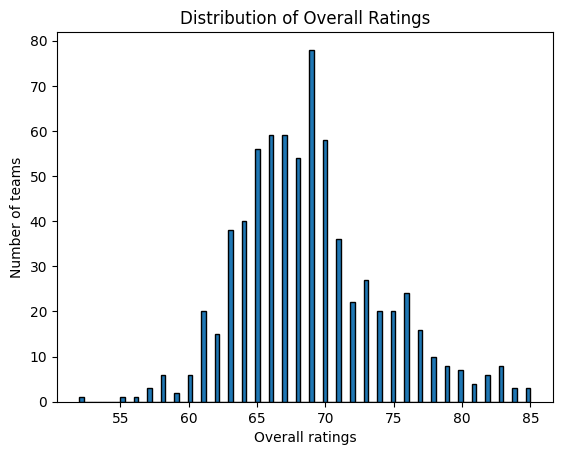

Minimum Overall value:  52
Maximum Overall value:  85
The most frequent range of values in the Overall column is: (60, 70]
Most frequent value of Overall column: 69
Number of occurrences of most frequent value in Overall column: 78


In [15]:
column_name = 'Overall'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()

# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, 101, 10))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)


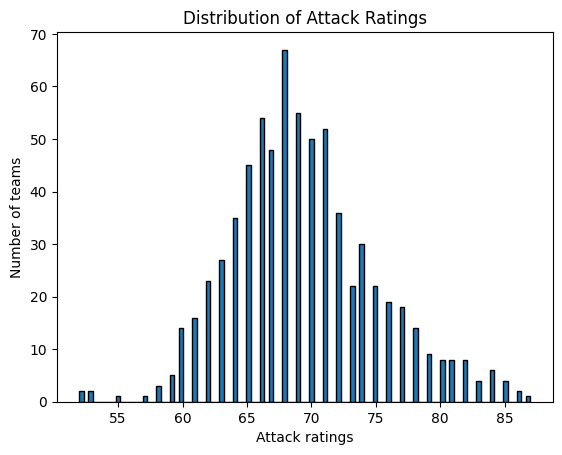

Minimum Attack value:  52
Maximum Attack value:  87
The most frequent range of values in the Attack column is: (60, 70]
Most frequent value of Attack column: 68
Number of occurrences of most frequent value in Attack column: 67


In [19]:
column_name = 'Attack'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()

# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, 101, 10))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)


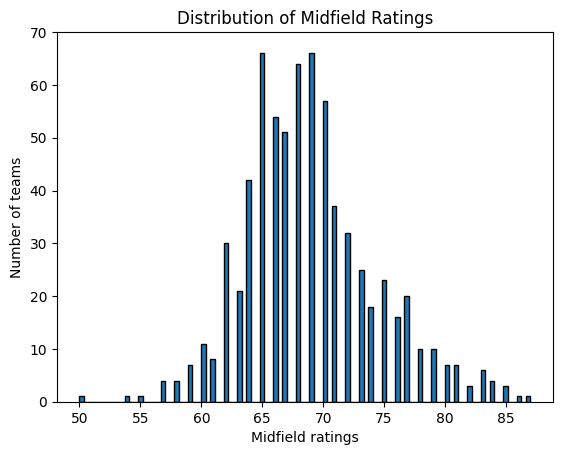

Minimum Midfield value:  50
Maximum Midfield value:  87
The most frequent range of values in the Midfield column is: (64, 72]
Most frequent value of Midfield column: 65
Number of occurrences of most frequent value in Midfield column: 66


In [17]:
column_name = 'Midfield'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()
# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, int(value_max + value_min), int(value_max / 10) ))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)


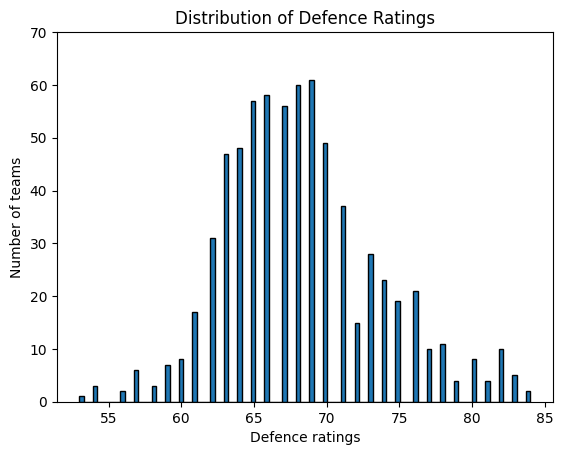

Minimum Defence value:  53
Maximum Defence value:  84
The most frequent range of values in the Defence column is: (64, 72]
Most frequent value of Defence column: 69
Number of occurrences of most frequent value in Defence column: 61


In [18]:
column_name = 'Defence'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()
# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, int(value_max + value_min), int(value_max / 10) ))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)


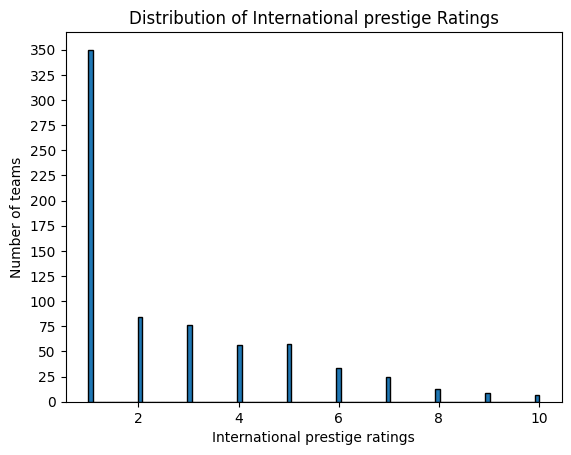

Minimum International prestige value:  1
Maximum International prestige value:  10
The most frequent range of values in the International prestige column is: (0, 1]
Most frequent value of International prestige column: 1
Number of occurrences of most frequent value in International prestige column: 350


In [20]:
column_name = 'International prestige'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()
# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, int(value_max + value_min), int(value_max / 10) ))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 25, 25))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)



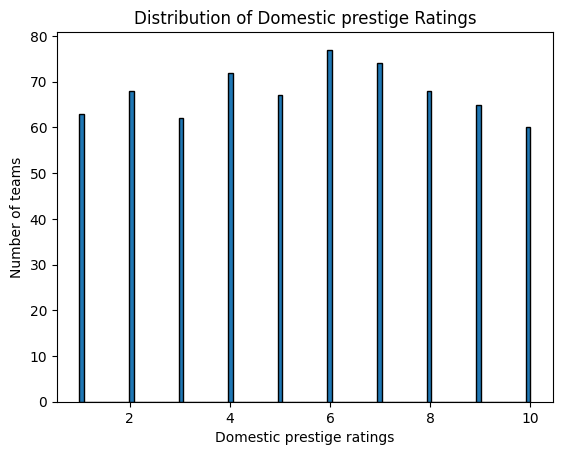

Minimum Domestic prestige value:  1.0
Maximum Domestic prestige value:  10.0
The most frequent range of values in the Domestic prestige column is: (5, 6]
Most frequent value of Domestic prestige column: 6.0
Number of occurrences of most frequent value in Domestic prestige column: 77


In [21]:
column_name = 'Domestic prestige'

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()

# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, int(value_max + value_min), int(value_max / 10) ))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)



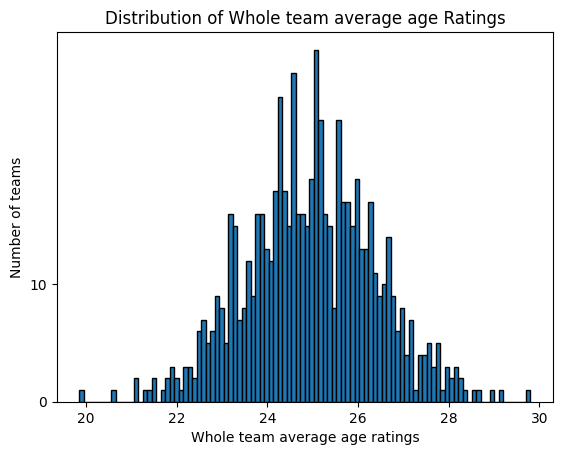

Minimum Whole team average age value:  19.86
Maximum Whole team average age value:  29.8
The most frequent range of values in the Whole team average age column is: (20, 30]
Most frequent value of Whole team average age column: 25.07
Number of occurrences of most frequent value in Whole team average age column: 9


In [22]:
column_name = "Whole team average age"

plt.hist(df[column_name], 100, edgecolor="black")

plt.xlabel(column_name + " ratings")
plt.ylabel("Number of teams")
plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()

# Divide the column into bins of width 10
bins = pd.cut(df[column_name], bins=range(0, 101, 10))

# Count the number of occurrences of each bin
bin_counts = bins.value_counts()

# Find the bin with the highest count
most_frequent_bin = bin_counts.idxmax()

most_frequent_value = df[column_name].mode()[0]

num_occurrences = (df[column_name] == most_frequent_value).sum()

plt.yticks(range(0, num_occurrences + 10, 10))

plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)



Ví dụ về cách vẽ biểu đồ bar chart cho các cột không phải số của dataframe:



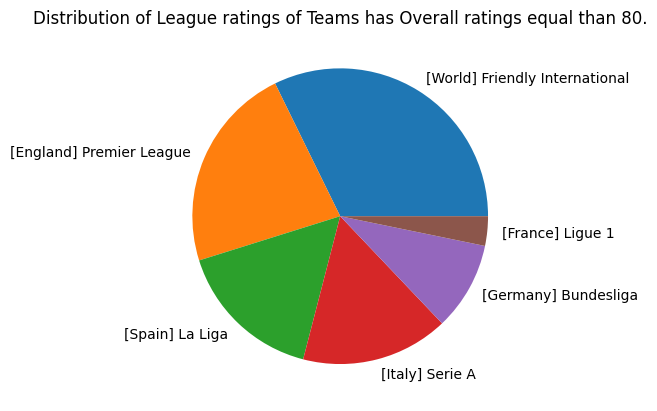

Minimum League value:  [Argentina] Liga Profesional
Maximum League value:  [World] Friendly International
The most frequent range of values in the League column is: (20, 30]
Most frequent value of League column: 25.07
Number of occurrences of most frequent value in League column: 9


In [23]:
column_name = 'League'

# plt.hist(df[column_name], 100, edgecolor="black")

# plt.xlabel(column_name + " ratings")
# plt.ylabel("Number of teams")
# plt.title("Distribution of " + column_name + " Ratings")

value_min = df[column_name].min()
value_max = df[column_name].max()

df_filtered = df[df['Overall'] >= 80]

# Count the number of occurrences of each bin
value_counts = df_filtered['League'].value_counts()

# Vẽ biểu đồ tròn
plt.pie(value_counts.values,autopct='',labels = value_counts.index)
plt.title("Distribution of " + column_name + " ratings of Teams has Overall ratings equal than 80.")
plt.show()

# # Find the bin with the highest count
# most_frequent_bin = bin_counts.idxmax()

# most_frequent_value = df[column_name].mode()[0]

# num_occurrences = (df[column_name] == most_frequent_value).sum()

# plt.yticks(range(0, num_occurrences + 10, 10))

# plt.show()

print("Minimum " + column_name + " value: ", value_min)
print("Maximum " + column_name + " value: ", value_max)
print("The most frequent range of values in the " + column_name + " column is:", most_frequent_bin)
print("Most frequent value of " + column_name + " column:", most_frequent_value)
print("Number of occurrences of most frequent value in " + column_name + " column:", num_occurrences)




* Nhận xét: Trong 100 đội bóng thì có 11 đội bóng tham gia giải Spain Laliga

## C. Đặt các câu hỏi có ý nghĩa cần trả lời

### 5 câu hỏi mà nhóm trả lời bằng dữ liệu nêu trên:

**Câu hỏi 1:** Các đội bóng nào có trung bình tuổi cao nhất và thấp nhất?
>Ý nghĩa: câu hỏi này sẽ giúp phân tích đội hình của các đội bóng có tuổi trung bình cao và thấp, từ đó đánh giá khả năng cạnh tranh, phong độ, kinh nghiệm của đội bóng đó.

In [24]:
top_10_max = df.nlargest(10, 'Whole team average age')[['Name', 'Whole team average age']]
top_10_min = df.nsmallest(10, 'Whole team average age')[['Name', 'Whole team average age']]

display(top_10_max.rename(columns={'Name': 'Các đội bóng nào có trung bình tuổi cao nhất'}))
display(top_10_min.rename(columns={'Name': 'Các đội bóng nào có trung bình tuổi thấp nhất'}))

,Các đội bóng nào có trung bình tuổi cao nhất,Whole team average age
284,América Mineiro,29.80
510,Suwon,29.14
78,São Paulo,29.00
192,China PR,28.70
240,Palmeiras,28.60
324,Shandong Taishan,28.39
523,Chengdu Rongcheng,28.29
311,Northern Ireland,28.22
508,Al Feiha,28.17
299,Ulsan,28.14


,Các đội bóng nào có trung bình tuổi thấp nhất,Whole team average age
610,UCD,19.86
680,Freiburg II,20.57
424,Nordsjælland,21.08
608,Drogheda United,21.14
678,Borussia Dortmund II,21.29
477,Villarreal II,21.41
449,Bordeaux,21.46
601,Shelbourne,21.54
167,Salzburg,21.68
91,Genk,21.75



**Câu hỏi 2:** Đội bóng nào có Overall cao nhất trong danh sách?
>Ý nghĩa: Câu hỏi này giúp tìm ra đội bóng có Overall cao nhất trong danh sách, từ đó đánh giá mức độ mạnh yếu của các đội bóng trong danh sách.

In [25]:
top_1_max = df.nlargest(1, ['Overall'])[['Name', 'Overall']]
display(top_1_max.rename(columns={'Name': 'Đội bóng có Overall cao nhất trong danh sách'}))

,Đội bóng có Overall cao nhất trong danh sách,Overall
0,Manchester City,85



**Câu hỏi 3:** Đội bóng nào có Attack cao nhất trong danh sách?
> Ý nghĩa: Câu hỏi này giúp tìm ra đội bóng có chỉ số tấn công (Attack) cao nhất trong danh sách, từ đó đánh giá sức mạnh tấn công của các đội bóng.


In [ ]:
top_1_max = df.nlargest(1, ['Attack'])[['Name','Attack']]
display(top_1_max.rename(columns={'Name': 'Đội bóng có Attack cao nhất trong danh sách'}))

,Đội bóng có Attack cao nhất trong danh sách,Attack
97,Al Nassr,87



**Câu hỏi 4:** Có bao nhiêu đội bóng đến từ mỗi quốc gia?
>Ý nghĩa: Câu hỏi này giúp chúng ta có thể biết được sự phân bố của các đội bóng theo từng quốc gia. Điều này có thể giúp ta phân tích sức mạnh của bóng đá từng quốc gia, cũng như đánh giá chất lượng của từng giải đấu.


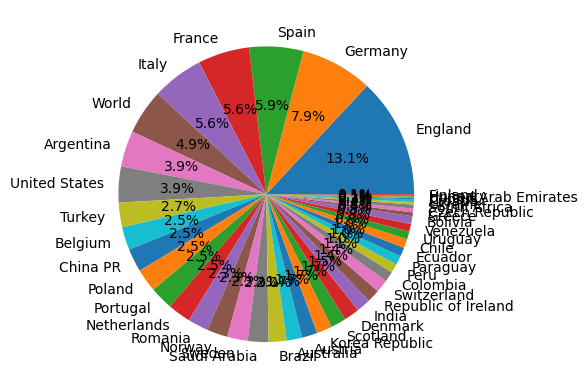

In [26]:
df['Country'] = df['League'].str.split(']').str[0].str.strip('[')
country_counts = df['Country'].value_counts()

# print(df['Country'].value_counts())
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%')
plt.show()


**Câu hỏi 5:** Số lượng đội bóng theo Uy tín quốc tế (International prestige)? 

> Ý nghĩa: Câu hỏi này giúp chúng ta có cái nhìn tổng quan về sự phân bố đội bóng theo mức độ uy tín quốc tế trên trang web sofifa.com. Số lượng đội bóng theo mức độ uy tín sẽ phản ánh mức độ quan tâm của cộng đồng đối với các giải đấu bóng đá trên toàn thế giới và cũng giúp chúng ta đánh giá được mức độ cạnh tranh của các giải đấu này.


International prestige
1     350
2      84
3      76
4      56
5      57
6      34
7      25
8      13
9       9
10      7
dtype: int64


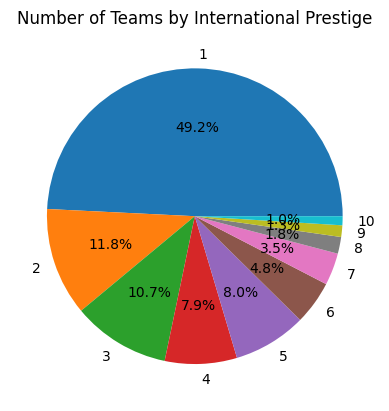

In [27]:
prestige_counts = df.groupby('International prestige').size()
print(prestige_counts)
plt.pie(prestige_counts.values, labels=prestige_counts.index, autopct='%1.1f%%')
plt.title('Number of Teams by International Prestige')
plt.show()



**Nguồn cảm hứng của câu hỏi?**

> Tham khảo các thông tin liên quan đến đội bóng từ tin tức bóng đá trên các trang web chuyên về thể thao, các trận đấu bóng đá gần đây, thống kê về các cầu thủ và đội bóng.

# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

### A. Mô hình hóa dữ liệu và đánh giá mô hình

### THUẬT TOÁN PHÂN LOẠI RANDOM FOREST

Random Forests là thuật toán học có giám sát

##### Phân loại đội bóng (uy tín, không uy tín) dựa trên các đặc trưng của đội bóng như (Overall, International prestige, Domestic prestige) sử dụng thuật toán phân loại Random Forest

Để giải quyết bài toán này, chúng ta sẽ thực hiện các bước sau:

1. Khám phá và tiền xử lý dữ liệu.
2. Tạo tập huấn luyện và tập kiểm tra.
3. Huấn luyện mô hình phân loại Random Forest.
4. Đánh giá mô hình.

**Bước 1: Khám phá và tiền xử lý dữ liệu**

* Kiểm tra các cột thiếu dữ liệu

In [28]:
print(df.isna().sum())


Name                        0
League                      0
Overall                     0
Attack                      0
Midfield                    0
Defence                     0
Home stadium               25
Rival team                  0
International prestige      0
Domestic prestige          35
Club worth                 57
Starting XI average age     0
Whole team average age      0
Captain                     0
Short free kick             0
Long free kick              0
Left short free kick        0
Right short free kick       0
Penalties                   2
Left corner                 0
Right corner                1
Country                     0
dtype: int64


* Xóa các dòng dữ liệu NaN ở cột Domestic prestige

In [29]:
df.dropna(subset=['Domestic prestige'], inplace=True)

**Bước 2: Tạo tập huấn luyện và tập kiểm tra**

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

* Chọn các đặc trưng để sử dụng cho mô hình phân loại

In [31]:
features = ['Overall', 'International prestige', 'Domestic prestige']
X = df[features]

* Tạo nhãn dựa trên điều kiện uy tín (ví dụ: Overall >= 75 và (International prestige >= 5 hoặc Domestic prestige>= 5))

In [32]:
y = (df['Overall'] >= 70) & ((df['International prestige'] >= 5) | (df['Domestic prestige'] >= 5))

In [33]:
y

0       True
1       True
2       True
3       True
5       True
       ...  
706    False
707    False
708    False
709    False
710    False
Length: 676, dtype: bool

* Chia dữ liệu thành tập huấn luyện và tập kiểm tra

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Bước 3: Huấn luyện mô hình phân loại Random Forest**

* Tạo mô hình Random Forest với 1000 cây quyết định

In [35]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42)

* Huấn luyện mô hình với dữ liệu huấn luyện

In [36]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

**Bước 4: Đánh giá mô hình**

* Dự đoán nhãn cho tập kiểm tra

In [37]:
y_pred = clf.predict(X_test)

* Tính độ chính xác của mô hình

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print("Độ chính xác:", accuracy)

Độ chính xác: 1.0


* Tính bảng phân loại

In [39]:
report = classification_report(y_test, y_pred)
print("Bảng phân loại:\n", report)

Bảng phân loại:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00        90
        True       1.00      1.00      1.00        46

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136



* Tính ma trận nhầm lẫn

In [40]:
cm = confusion_matrix(y_test, y_pred)
print("Ma trận nhầm lẫn:\n", cm)

Ma trận nhầm lẫn:
 [[90  0]
 [ 0 46]]


Thể hiện ma trận nhầm lẫn qua hình ảnh:

<Axes: >

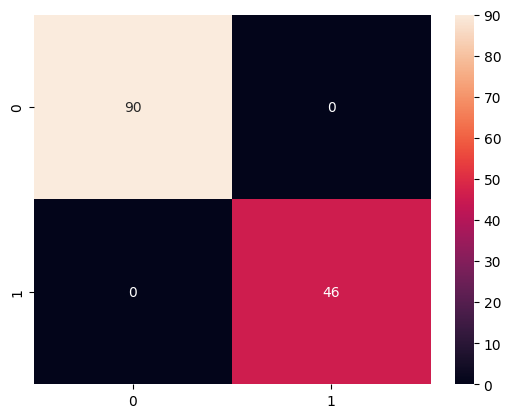

In [41]:
import seaborn as sns
sns.heatmap(cm, annot=True)

 ** Nhận xét:
 
 - 55//55 đội bóng uy tín được dự đoán chính xác
 - 29/29 đội bóng không uy tín được dự đoán chính xác
 - 0 có đổi bóng nào dự đoán sai

Sau khi thực hiện các bước trên, bạn sẽ có được kết quả đánh giá mô hình phân loại đội bóng (uy tín, không uy tín) sử dụng thuật toán Random Forest.

### THUẬT TOÁN HỒI QUY TUYẾN TÍNH

##### Khai báo thư viện

In [ ]:
!pip install seaborn

** Vẽ các mối quan hệ theo cặp trong một tập dữ liệu.

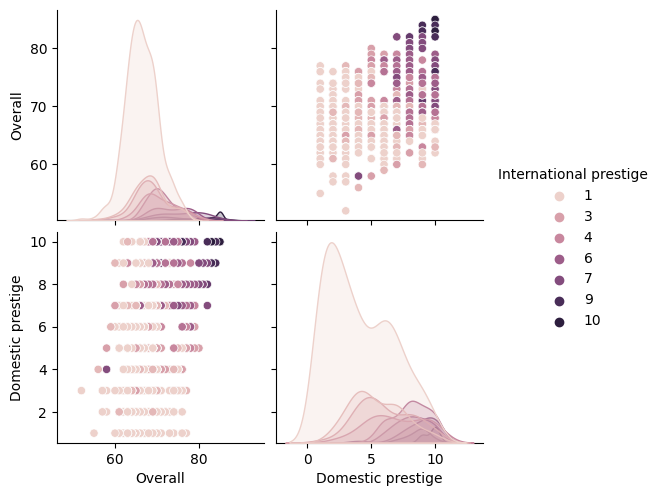

In [43]:
import seaborn as sns
sns.pairplot(X,hue="International prestige")

In [47]:
from sklearn.linear_model import LinearRegression

 ##### Cần tạo một thể hiện của Linear Regression, gán giá trị này cho một biến có tên là model

In [45]:
model = LinearRegression()
model.fit(X=X_train,y = y_train)

LinearRegression()

In [46]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(X=X_test)
accuracy = r2_score(y_test,y_pred)
print("Độ chính xác:", accuracy)

Độ chính xác: 0.5297449635752653


Text(0, 0.5, 'Kết quả dự đoán')

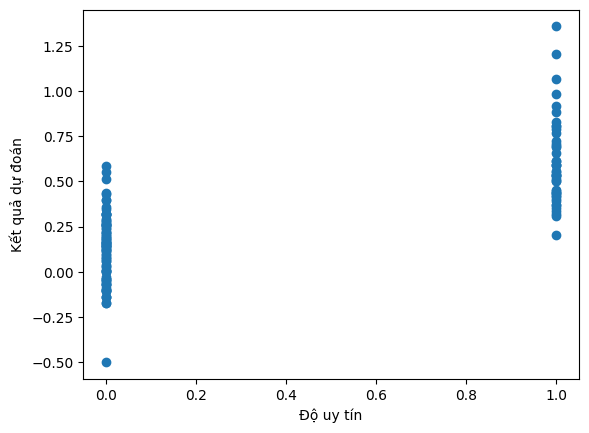

In [48]:
plt.scatter(y_test, y_pred)
plt.xlabel("Độ uy tín")
plt.ylabel("Kết quả dự đoán")

Bảng hệ số ước lượng: Cho biết độ biến thiên của thuộc tính so với giá trị trung bình

In [49]:
pd.DataFrame(model.coef_, X.columns, columns = ['Coeff'])

,Coeff
Overall,0.035702
International prestige,0.051188
Domestic prestige,0.031825


Các thuộc tính có độ lệch chuẩn tương đối bằng nhau từ 3.6-4.1%

Mức độ lỗi của mô hình

In [50]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.10525820992638418


### Nhận xét:
Độ chính xác của mô hình hồi quy tuyến tính thấp hơn so với mô hình random forest.

Tùy theo data mà nên chọn loại mô hình hóa phù hợp

### PHẦN 3: TỔNG HỢP KẾT QUẢ


Báo cáo đánh giá đồ án của Nhóm 7:

Những khó khăn đã gặp phải:
- Trong quá trình thực hiện đồ án, gặp khó khăn khi phân tích dữ liệu. Tuy nhiên, thông qua việc tra cứu tài liệu và học hỏi từ thành viên trong nhóm, vượt qua được khó khăn này.
- Trong quá trình thực hiện đồ án, gặp khó khăn khi trình bày kết quả bằng biểu đồ. Tuy nhiên, sau khi học hỏi từ đồng đội và tìm hiểu thêm về cách sử dụng thư viện trực quan hóa dữ liệu, khắc phục được khó khăn này.

Những kiến thức học hỏi được:

- Học được cách thu thập và phân tích dữ liệu bằng ngôn ngữ Python. Đồng thời, học được cách sử dụng các thư viện hỗ trợ trong việc xử lý dữ liệu như Pandas và Numpy.
- Học được cách trình bày kết quả bằng các biểu đồ trực quan. Đồng thời, nâng cao được kỹ năng lập trình bằng ngôn ngữ Python thông qua việc thực hiện đồ án.
Nhóm của bạn:

Nếu có nhiều thời gian hơn, sẽ cố gắng thực hiện một số công việc như sau:

- Tìm hiểu thêm về các thư viện hỗ trợ trong việc xử lý dữ liệu để có thể áp dụng vào việc phân tích dữ liệu phức tạp hơn.
- Tìm hiểu và áp dụng các phương pháp phân tích dữ liệu tiên tiến để có thể đưa ra kết luận chính xác và hữu ích hơn.
Nâng cao kỹ năng lập trình bằng việc thực hiện các bài tập và dự án thực tế khác để có thể áp dụng kiến thức vào các dự án thực tế trong tương lai.